In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

In [2]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy


palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


## LOAD DATA

In [3]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/features.xlsx')

In [4]:
from datasets.arrow_dataset import Dataset

# load the dataset from disk
ds = Dataset.load_from_disk('../lc-project-data/features.arrow')
ds

Dataset({
    features: ['sex', 'age', 'dag', 'MED-Analgesics', 'MED-Anesthetics', 'MED-Antibacterials', 'MED-Anticonvulsants', 'MED-Antidepressants\xa0', 'MED-Antifungals', 'MED-Antimigraine-agents', 'MED-Antiparasitics', 'MED-Antiparkinson-agents', 'MED-Antipsychotics', 'MED-Antispasticity-agents', 'MED-Antivirals', 'MED-Blood-glucose-regulators', 'MED-Blood-products', 'MED-Cardiovascular-agents', 'MED-Dermatological-agents', 'MED-Gastrointestinal-agents', 'MED-Hormonal-agents-(adrenal)', 'MED-Hormonal-agents-(sex-hormones)', 'MED-Hormonal-agents-(thyroid)', 'MED-Hormone-suppressant-(thyroid)', 'MED-Immunological-agents', 'MED-Inflammatory-bowel-disease-agents', 'MED-Metabolic-bone-disease-agents', 'MED-Ophthalmic-agents', 'MED-Respiratory-tract-agents', 'MED-Skeletal-muscle-relaxants', 'SYMPT-joint_pain_arthralgia___1', 'SYMPT-joint_pain_arthralgia___2', 'SYMPT-confusion_altered_mental_s___1', 'SYMPT-confusion_altered_mental_s___2', 'SYMPT-red_eye_conjunctivitis___1', 'SYMPT-red_eye

In [540]:
# convert to pandas dataframe
df = ds.to_pandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Columns: 420 entries, sex to LC_STATUS
dtypes: float64(366), int64(53), object(1)
memory usage: 18.6+ MB


## LC+, LC-, HC

In [541]:
LC_pos = df.query('LC_STATUS == "LC_POS"')
LC_neg = df.query('LC_STATUS == "LC_NEG"')
HC = df.query('LC_STATUS == "HC"')


In [542]:
LC_pos.shape, LC_neg.shape, HC.shape

((2461, 420), (3260, 420), (81, 420))

In [543]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass


## SITES

In [544]:
site_name_dict = {1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                    4: 'RIO',
                    5: 'LUS',
}

In [545]:
# map dag using site_name_dict
LC_pos['SITE'] = LC_pos['dag'].map(site_name_dict)

In [546]:
# get the range of indices for each site
site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

SITE
MTL       (0, 1764)
RIO    (2913, 3571)
LUS    (3709, 5146)
SAN    (5180, 5406)
LDN    (5500, 5801)
dtype: object

In [547]:
# drop RIO and LUS
# LC_pos = LC_pos.query('SITE != "RIO" and SITE != "LUS"')
LC_pos = LC_pos.query(' SITE != "LUS"')
LC_pos['SITE'].value_counts()

SITE
MTL    916
RIO    659
SAN    227
LDN    110
Name: count, dtype: int64

In [548]:
# get the range of indices for each site
site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

SITE
MTL       (0, 1764)
RIO    (2913, 3571)
SAN    (5180, 5406)
LDN    (5500, 5801)
dtype: object

# CLUSTERING

In [549]:
# clustering
from sklearn.preprocessing import MinMaxScaler

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

In [550]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos

# drop certain columns, to experiment with effect on clustering
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED').columns)

print(LC_pos_.shape)

(1912, 115)


In [551]:
# drop the dag and SITE columns - these might guide the clustering algorithm to cluster by site

X = scaler.fit_transform(LC_pos_.drop(columns=['dag', 'SITE'])) 

# the clustering algorithms depend on the data being complete
X = X.dropna()
# X.fillna(0, inplace = True)

# a reference copy of the data, for later use in other clustering algorithms
X_ref = deepcopy(X)
print(X.shape)

(1821, 113)


## Use UMAP to visualize the data and cluster

In [552]:
from hdbscan import HDBSCAN, approximate_predict, all_points_membership_vectors
from umap import UMAP

hdb_parms = {
                'min_cluster_size': 50,
                'prediction_data': True,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.5,
                # 'min_samples': 5,
            }

umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
            }


# instantiate the clustering and dim reduction objects
hdb_umap   = HDBSCAN(**hdb_parms)
umap_      = UMAP(**umap_parms)

In [553]:
# dimension reduction
umap_embeddings = umap_.fit_transform(X)

# clustering on the reduced data
hdb_umap.fit(umap_embeddings)
# get the cluster vectors
cvec = all_points_membership_vectors(hdb_umap)
# cluster labels are the maximally probable cluster
cluster_labels = np.argmax(cvec, axis = 1)

print(f"Found {len(np.unique(cluster_labels))} clusters")

/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Found 8 clusters


In [554]:
# make a plotting dataframe
plot_df = pd.DataFrame(umap_embeddings, columns = ["x", "y"], index = X.index)
plot_df["hdb_cluster"]     = hdb_umap.labels_
plot_df["hdb_prob"]        = hdb_umap.probabilities_
plot_df["hdb_cluster_max"] = np.argmax(all_points_membership_vectors(hdb_umap), axis = 1)
plot_df["Site"]            = LC_pos_["dag"].map(site_name_dict)


In [555]:
# get the centroids of the umap coordinates by cluster
umap_centroids = pd.DataFrame(umap_embeddings, 
                         columns = ["x", "y"]).assign(cluster = cluster_labels).groupby("cluster").mean()


In [556]:
# make a list of colours, desaturated by the probability of the cluster
plot_df["colour"] = plot_df["hdb_cluster"].map(palette_dict)
plot_df["colour"] = plot_df["colour"].apply(lambda x: mc.to_rgba(x, alpha = 0.5))

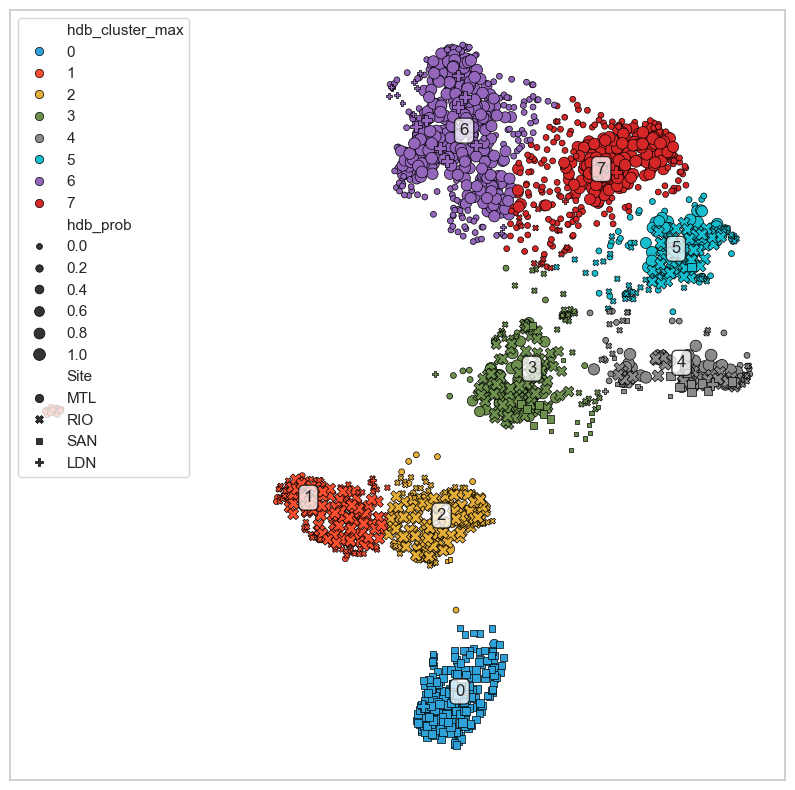

In [557]:
# plot the clusters

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(
                data = plot_df, 
                x = "x", 
                y = "y", 
                # use the maximlly probable cluster for the hue
                hue      = "hdb_cluster_max", 
                # hue = "hdb_cluster", 
                palette   = palette_dict, 
                style     = "Site",
                # s=50, 
                size      = "hdb_prob",
                edgecolor = 'black', 
                linewidth = 0.5, 
                ax        = ax, 
                )

# make legend points larger
plt.legend(markerscale=1)

for i, centroid in umap_centroids.iterrows():

    # we don't need to show the noise category's label
    if i != -1:

        plt.annotate(
                        i,  # type: ignore
                        (centroid["x"], centroid["y"]),
                        bbox=dict(boxstyle="round,pad=0.3", 
                                    fc="white", 
                                    ec="black", 
                                    lw=1, 
                                    alpha=0.75)
                    )
    
# turn off axis labels and ticks
plt.xticks([]); plt.yticks([]);
plt.xlabel(""); plt.ylabel("");

plt.savefig('hdb_clusters.png', dpi = 300)

In [558]:
# # another way - cluster first in high-dim space, then reduce to 2D

# # cluster
# hdb_.fit(X)

# # get the cluster vectors
# cvec = all_points_membership_vectors(hdb_)

# # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(cvec, axis = 1)
# # umap
# X_umap = umap_.fit_transform(X, y = cluster_labels)
# # X_umap = umap_.fit_transform(X, )
# # X_umap = umap_.fit_transform(X, y = LC_pos["dag"])

# dplot2 = pd.DataFrame(X_umap, columns = ["x", "y"], index = X.index)
# dplot2["cluster"] = cluster_labels
# dplot2["Site"] = LC_pos_["dag"].map(site_name_dict)

# # plot the clusters
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.scatterplot(data = dplot2, x="x", y = "y", hue="cluster", s=50, palette = palette,  edgecolor='black', linewidth=0.5, ax = ax, style = "Site",)
# # make marker size larger
# plt.legend(markerscale=1)

In [559]:
# hdb_umap.condensed_tree_.plot(select_clusters=True, 
#                           selection_palette=palette, 
#                           label_clusters=True, 
#                           cmap = "viridis"
#                           )

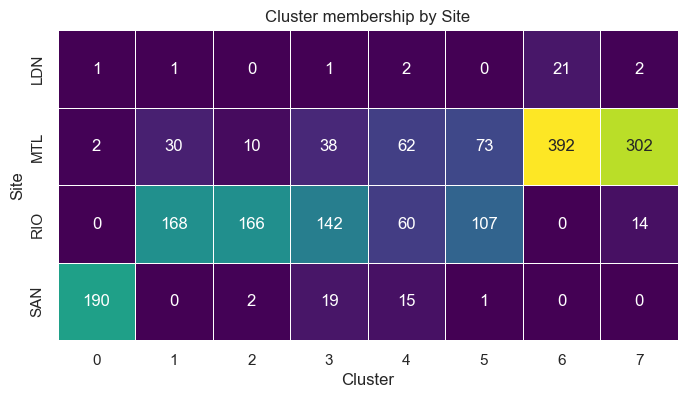

In [560]:
# augment the LCPOS with the cluster labels
LC_pos_.loc[X.index, "cluster"] = cluster_labels

cluster_by_site = LC_pos_.groupby("cluster")["SITE"].value_counts().unstack().T
cluster_by_site = cluster_by_site.fillna(0).astype(int)
cluster_by_site.columns = cluster_by_site.columns.astype(int)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cluster_by_site, robust = True, ax = ax, annot = True, fmt = "d", cmap = "viridis", square = True, linewidths = 0.5, linecolor = "w", cbar = False)

# rename axis labels
plt.xlabel("Cluster")
plt.ylabel("Site")

plt.title("Cluster membership by Site")
plt.savefig('cluster_membership.png', dpi = 300)


### Examine some of the clusters

In [561]:
# save the cluster labels to the original dataframe
X["cluster"] = cluster_labels

interesting = ["sex", "HHX-HIV or AIDS", "VAX-vaccinated"]

# get the means by cluster
X.groupby("cluster")[interesting].mean()



,sex,HHX-HIV or AIDS,VAX-vaccinated
cluster,,,
0,0.715026,0.000000,0.953368
1,0.678392,0.000000,0.959799
2,0.460674,0.000000,0.943820
3,0.575000,0.005000,0.965000
4,0.935252,0.000000,0.978417
5,0.027624,0.000000,0.939227
6,0.760291,0.004843,0.995157
7,0.459119,0.003145,0.984277


In [562]:
# how many HIV or AIDS in each cluster?
X.groupby("cluster")["HHX-HIV or AIDS"].value_counts(normalize = False).unstack().fillna(0)

HHX-HIV or AIDS,0.0,1.0
cluster,,
0,193.0,0.0
1,199.0,0.0
2,178.0,0.0
3,199.0,1.0
4,139.0,0.0
5,181.0,0.0
6,411.0,2.0
7,317.0,1.0


In [563]:
# how many HIV or AIDS in the original dataset?
LC_pos["HHX-HIV or AIDS"].value_counts(normalize = False)

HHX-HIV or AIDS
0.0    1831
1.0       4
Name: count, dtype: int64

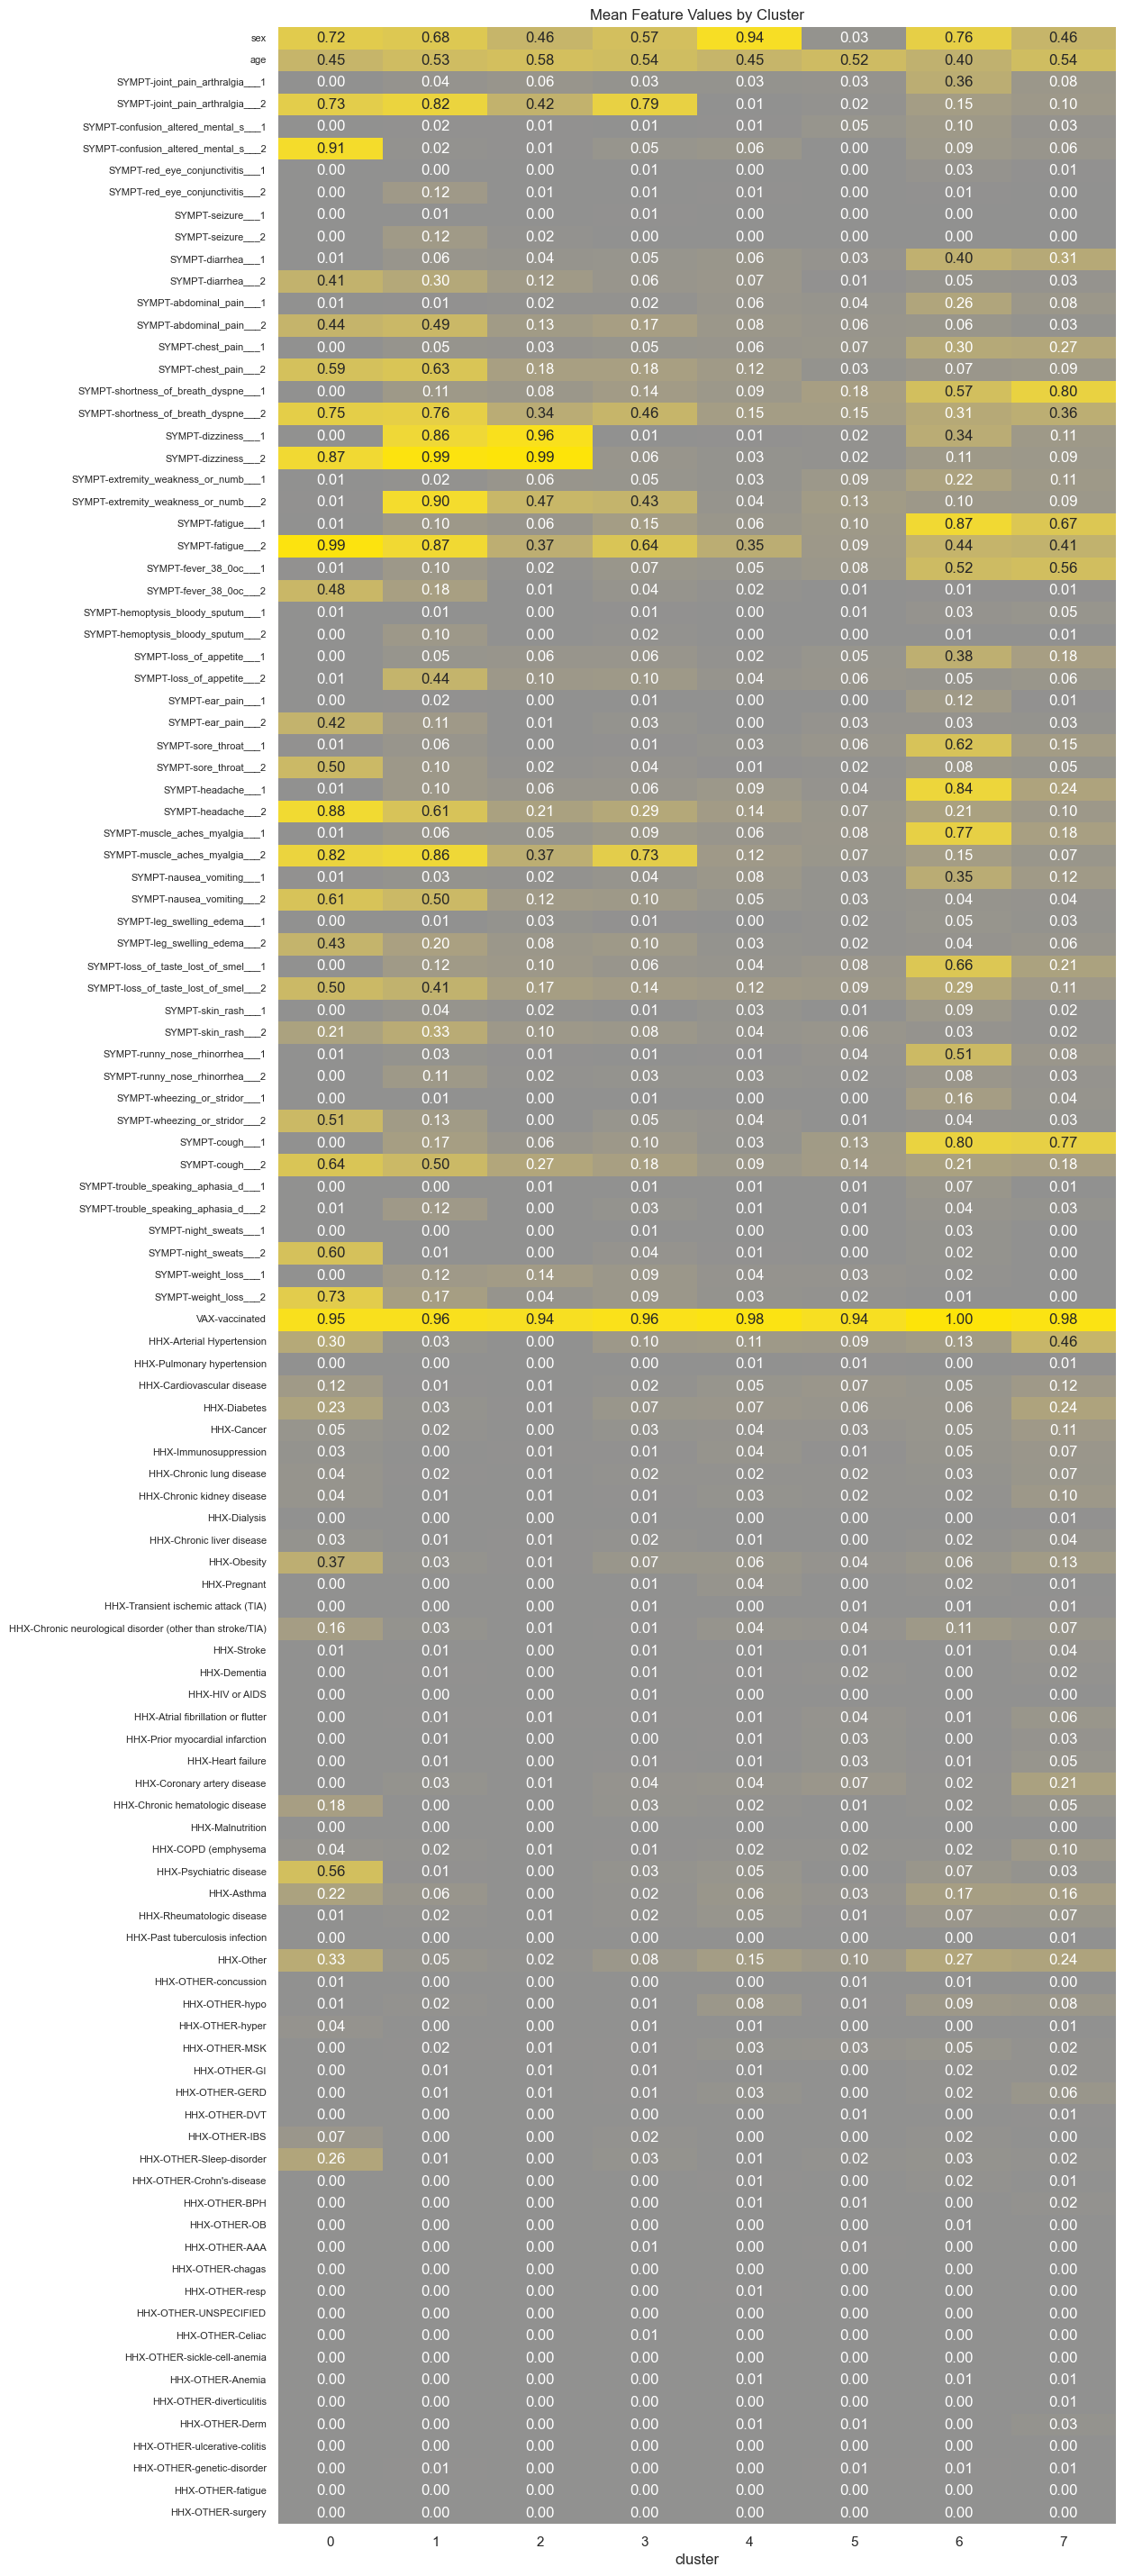

In [564]:
# heatmap of the means by cluster
fig, ax = plt.subplots(figsize=(12,36))

# apply lognorm to the colour scale
norm = mc.LogNorm(vmin = 0.01, vmax = 10.0)
norm = None

# get the means by cluster

mm = X.groupby("cluster").mean().T

# negative log transform
# mm = -np.log10(mm)


# use a diverging colour scheme
cmap = sns.diverging_palette(220, 20, as_cmap = True)

cmap = cc.cm.bjy

sns.heatmap(mm, robust = True, ax = ax, annot = True, fmt = ".2f", cmap = cmap,norm = norm, cbar = False, vmin = -1, vmax = 1)

plt.title("Mean Feature Values by Cluster")
# make font smaller
plt.yticks(fontsize = 8);
plt.savefig('mean_feature_values.png', dpi = 300)

In [565]:
# group by cluster and count the number of records
cluster_counts = X.groupby("cluster")

# pivot table for counts of specific symptoms
symptom_counts = X.groupby("cluster").sum()/cluster_counts.count()*100
symptom_counts[["HHX-HIV or AIDS", "VAX-vaccinated"]]

,HHX-HIV or AIDS,VAX-vaccinated
cluster,,
0,0.000000,95.336788
1,0.000000,95.979899
2,0.000000,94.382022
3,0.500000,96.500000
4,0.000000,97.841727
5,0.000000,93.922652
6,0.484262,99.515738
7,0.314465,98.427673


In [566]:
# group LC_pos by site and get Psychiatric disease counts
LC_pos.groupby("SITE")["HHX-Psychiatric disease"].value_counts().unstack().fillna(0)


HHX-Psychiatric disease,0.0,1.0
SITE,,
LDN,26.0,10.0
MTL,878.0,37.0
RIO,659.0,0.0
SAN,111.0,116.0


In [567]:
# sns.clustermap(X.drop(["cluster"], axis = 1), row_cluster = False, col_cluster = True, cmap = "viridis")

## Use IVIS to visualize the data and cluster

In [568]:
# load ivis module
from ivis import Ivis

XX = deepcopy(np.array(X_ref))

ivis = Ivis(k = 150, verbose = 0)
ivis.fit(XX)
ivis_embeddings = ivis.transform(XX)
hdb_ivis = HDBSCAN(**hdb_parms)
hdb_ivis.fit(ivis_embeddings)

HDBSCAN(cluster_selection_epsilon=0.5, cluster_selection_method='leaf',
        min_cluster_size=50, prediction_data=True)

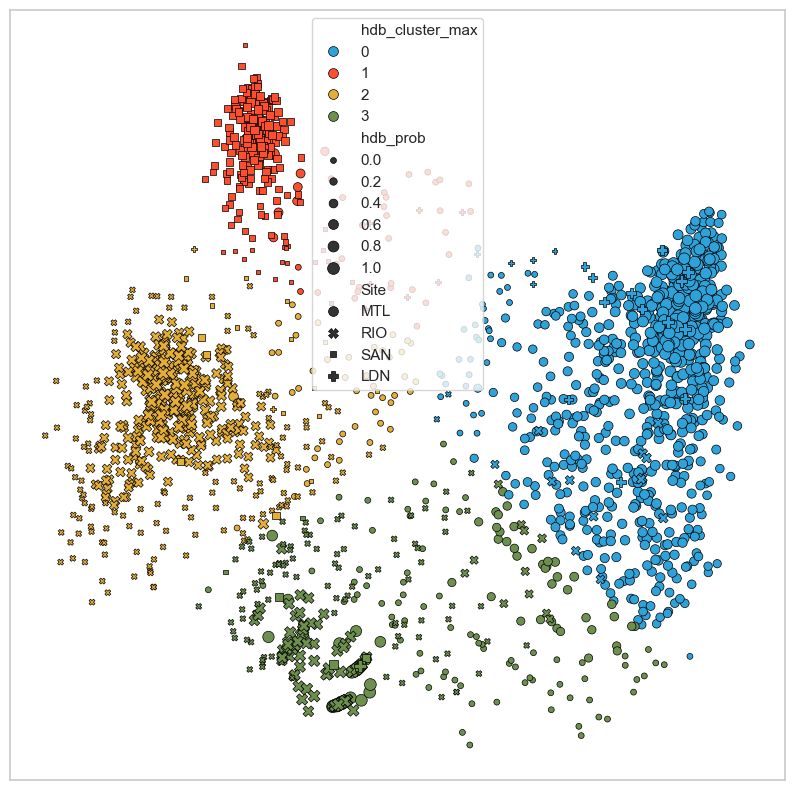

In [569]:
# make a plotting dataframe
ivis_df = pd.DataFrame(ivis_embeddings, columns = ["x", "y"], index = X.index)
ivis_df["cluster"]         = hdb_ivis.labels_
ivis_df["Site"]            = LC_pos_["dag"].map(site_name_dict)
ivis_df["hdb_prob"]        = hdb_ivis.probabilities_
ivis_df["hdb_cluster_max"] = np.argmax(all_points_membership_vectors(hdb_ivis), axis = 1)

# plot the embeddings
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(data = ivis_df, 
                x = "x",
                y = "y",
                s = 50,
                edgecolor = 'black', 
                hue       = "hdb_cluster_max",
                linewidth = 0.5, 
                palette   = palette_dict,
                style     = "Site",
                size      = "hdb_prob",
                ax = ax
                     )

# turn off axis labels and ticks
plt.xticks([]); plt.yticks([]);
plt.xlabel(""); plt.ylabel("");

## Use TSNE to visualize the data and cluster

In [570]:
# import TSNE from sklearn
from sklearn.manifold import TSNE

XX = deepcopy(X_ref)

tsne = TSNE(n_components = 2, perplexity = 30, random_state = 42)
tsne_embeddings = tsne.fit_transform(XX)
hdb_tsne = HDBSCAN(**hdb_parms)
hdb_tsne.fit(tsne_embeddings)

HDBSCAN(cluster_selection_epsilon=0.5, cluster_selection_method='leaf',
        min_cluster_size=50, prediction_data=True)

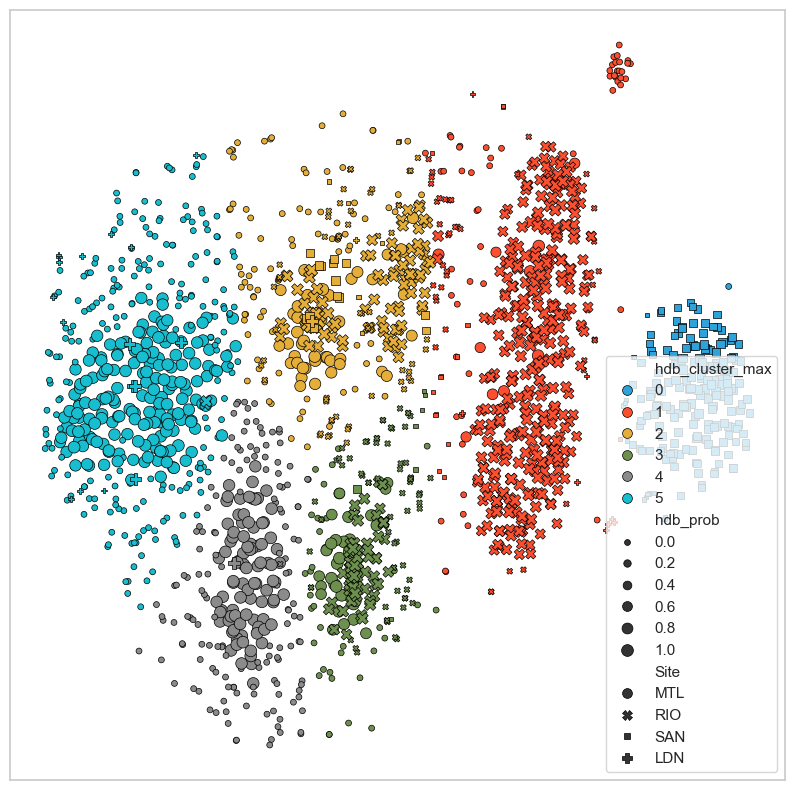

In [571]:

tsne_df = pd.DataFrame(tsne_embeddings, columns = ["x", "y"], index = X.index)
tsne_df["cluster"]         = hdb_tsne.labels_
tsne_df["Site"]            = LC_pos_["dag"].map(site_name_dict)
tsne_df["hdb_prob"]        = hdb_tsne.probabilities_
tsne_df["hdb_cluster_max"] = np.argmax(all_points_membership_vectors(hdb_tsne), axis = 1)

# plot the embeddings
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(data = tsne_df, 
                x = "x",
                y = "y",
                s = 50,
                edgecolor = 'black', 
                hue       = "hdb_cluster_max",
                linewidth = 0.5, 
                palette   = palette_dict,
                style     = "Site",
                size      = "hdb_prob",
                ax = ax
                     )

# turn off axis labels and ticks
plt.xticks([]); plt.yticks([]);
plt.xlabel(""); plt.ylabel("");